# DeViSE - A Deep Visual-Semantic Embedding Model

Paper: [Frome et al. 2013](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/41473.pdf)

In [1]:
from fastai.conv_learner import *
import fastText as ft
import torchvision.transforms as transforms
from fastai.io import get_data
from torchvision import models

In [2]:
torch.backends.cudnn.benchmark=True

In [3]:
arch = resnet34

In [4]:
model = models.resnet34(pretrained=True).cuda()

## Preparing Data
### Imagenet

In [5]:
PATH = Path('data/CLS-LOC')
TMP_PATH = PATH/'tmp'
TRANS_PATH = Path('data/translate/word_vectors')
PATH_TRAIN = PATH/'train'

In [6]:
sz = 224

In [7]:
arch = resnet50

In [8]:
ttfms, vtfms = tfms_from_model(arch, sz, transforms_side_on, max_zoom=1.1)

### Wordvectors

In [9]:
# !wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.zip

In [10]:
wordvectors = ft.load_model(str((TRANS_PATH/'wiki.en.bin')))

In [11]:
wordvectors.get_word_vector("cat").shape

(300,)

In [12]:
np.corrcoef(wordvectors.get_word_vector("house"), wordvectors.get_word_vector("bug"))

array([[1.    , 0.0998],
       [0.0998, 1.    ]])

In [13]:
np.corrcoef(wordvectors.get_word_vector("queen"), wordvectors.get_word_vector("king"))

array([[1.     , 0.64877],
       [0.64877, 1.     ]])

### Mapping imagenet classes to word vectors

In [14]:
words = wordvectors.get_words(include_freq=True)

In [15]:
words_frequencies_dict = {k:v for k,v in zip(*words)}  # contains word and respective frequency

In [16]:
words = sorted(words_frequencies_dict.keys(), key=lambda x: words_frequencies_dict[x])

In [17]:
len(words)  # contains all fastText english words in ascending order 

2519370

### List of the names of the 1000 imagenet classes

In [18]:
CLASSES_FN = 'imagenet_class_index.json'

In [19]:
get_data(f'http://files.fast.ai/models/{CLASSES_FN}', TMP_PATH/CLASSES_FN)

In [20]:
classIds_imagenet = dict(json.load((TMP_PATH/CLASSES_FN).open()).values())

In [21]:
classIds_imagenet['n01443537']

'goldfish'

Number of classes in imagenet:

In [22]:
len(classIds_imagenet)

1000

### List of 'all' english nouns according to WordNet:

In [23]:
WORDS_FN = 'classids.txt'
get_data(f'http://files.fast.ai/data/{WORDS_FN}', TMP_PATH/WORDS_FN)

In [24]:
classid_nouns = (TMP_PATH/WORDS_FN).open().readlines()

In [25]:
classid_nouns[:3]  # Look at the format. Imagenet uses WordNet classes :)

['n00001740 entity\n',
 'n00001930 physical_entity\n',
 'n00002137 abstraction\n']

In [26]:
classIds_wordnet = dict(l.strip().split() for l in classid_nouns)

Number of classes in wordnet:

In [27]:
len(classIds_wordnet)

82115

### Map the ~80k wordnet ids to their respective wordvectors
First, create a dictionary that maps the million most frequent words (in fastText) to their respective wordvector:

In [28]:
len(words)

2519370

In [29]:
wordvec_dict = {w.lower() : wordvectors.get_word_vector(w) for w in words[-1000000:]}

In [30]:
wordvec_dict['cat'].shape

(300,)

In [31]:
wordvec_dict["fish"].shape

(300,)

In [32]:
wordnetId_2_wordvec = [(key, wordvec_dict[val.lower()]) for key, val in classIds_wordnet.items() if val.lower() in wordvec_dict]

In [33]:
len(wordnetId_2_wordvec)

49469

In [34]:
wordnetId_2_wordvec_dict = dict(wordnetId_2_wordvec)

**We found the wordvectors for ~49k words in WordNet**

### Map the 1000 imagenet ids to their respective wordvectors

In [35]:
imagenetId_2_wordvec = [(key, wordvec_dict[val.lower()]) for key, val in classIds_imagenet.items() if val.lower() in wordvec_dict]

In [36]:
len(imagenetId_2_wordvec)

574

**We found the wordvectors for 574 classes in imagenet.**

**Let's finally create a mapping of the ~49k words in wordnet for which we found a wordvector in fastText to their respective wordvector.**

In [37]:
className_2_wordvec = [[classIds_wordnet[id], vec] for id, vec in wordnetId_2_wordvec]

Remove duplicates. This has bad time complexity obviously but it works in ~5s so I'll ignore this for now...

In [38]:
className_2_wordvec_without_dups = []
encountered_classNames = []

for word, wordvec in className_2_wordvec:
    if encountered_classNames.count(word) == 0:
        className_2_wordvec_without_dups.append([word, wordvec])
        encountered_classNames.append(word)

In [39]:
pickle.dump(className_2_wordvec_without_dups, (PATH/'className_2_wordvec_without_dups.pkl').open('wb'))

## Create dataset for training
The inputs are images from imagenet, the labels are wordvectors from FastText

In [40]:
input_images = []
label_wordvecs = []

In [41]:
for d in PATH_TRAIN.iterdir():
    if d.name not in wordnetId_2_wordvec_dict: continue
    wordvec = wordnetId_2_wordvec_dict[d.name]
    for f in d.iterdir():
        input_images.append(str(f.relative_to(PATH)))
        label_wordvecs.append(wordvec)

In [42]:
input_images[:3]

['train/n01667778/n01667778_17582.JPEG',
 'train/n01667778/n01667778_4936.JPEG',
 'train/n01667778/n01667778_3675.JPEG']

In [43]:
len(input_images), len(label_wordvecs)

(739526, 739526)

In [44]:
label_wordvecs = np.stack(label_wordvecs)

In [45]:
label_wordvecs.shape

(739526, 300)

In [46]:
val_indcs = get_cv_idxs(len(input_images), val_pct=0.01)

In [47]:
tfms = tfms_from_model(arch, sz, transforms_side_on, max_zoom=1.1)

In [48]:
modeldata = ImageClassifierData.from_names_and_array(PATH, input_images, label_wordvecs, val_idxs=val_indcs, classes=None, tfms=tfms, continuous=True, bs=128)

In [49]:
x,y = next(iter(modeldata.val_dl))

In [50]:
x.shape, y.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128, 300]))

### Create the model

In [51]:
for param in model.parameters():
    param.requires_grad = False

In [52]:
p=0.1

In [53]:
model.fc = nn.Sequential(nn.BatchNorm1d(512),
                         nn.Dropout(p),
                         nn.Linear(in_features=512, out_features=512, bias=True),
                         nn.ReLU(),
                         nn.BatchNorm1d(512),
                         nn.Dropout(p),
                         nn.Linear(in_features=512, out_features=300, bias=True))

In [54]:
learn = Learner(modeldata, SingleModel(to_gpu(model)))

### Train the model

In [55]:
learn.opt_fn = partial(optim.Adam, betas=(0.9, 0.99))

In [56]:
def cos_loss(input, target):
    return 1 - F.cosine_similarity(input, target).mean()

# does not care about th lengths of the vectors, only the angle between them
# cosine sim returns 1 if two vectors point in same direction, 0 if angle is 90 degrees
# to convert to loss we do 1 - cosine sim so that the loss is smaller when the angle is smaller

In [57]:
learn.crit = cos_loss

In [73]:
learn.lr_find(start_lr=1e-4, end_lr=1e15)

epoch      trn_loss   val_loss                                  
    0      1.0        1.0       



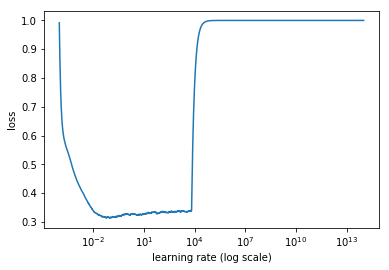

In [77]:
learn.sched.plot(n_skip=0, n_skip_end=300)

In [78]:
lr = 1e-2
wd = 1e-7

In [79]:
learn.fit(lr, 1, cycle_len=5, wds=wd, use_clr=(20,10))

epoch      trn_loss   val_loss                                  
    0      0.216088   0.1515    
    1      0.206034   0.135275                                  
    2      0.205923   0.131817                                  
    3      0.200415   0.128312                                  
    4      0.198345   0.126672                                  



[0.1266719105116333]

In [80]:
learn.save('model1')

In [81]:
learn.load('model1')

In [82]:
learn.fit(lr, 1, cycle_len=5, wds=wd, use_clr=(20,10))

epoch      trn_loss   val_loss                                  
    0      0.210491   0.135097  
    1      0.204235   0.130115                                  
    2      0.205884   0.130088                                  
    3      0.196507   0.124716                                  
    4      0.199349   0.122149                                  



[0.1221494674602016]

In [83]:
learn.save('model2')

In [61]:
learn.load('model2')

In [105]:
lr = 1e-3
wd = 1e-7

In [106]:
learn.fit(lr, 1, cycle_len=5, wds=wd, use_clr=(20,10))

epoch      trn_loss   val_loss                                  
    0      0.156351   0.117418  
    1      0.161498   0.118112                                  
    2      0.160972   0.117604                                   
    3      0.157842   0.117846                                  
    4      0.160269   0.117712                                  


[0.117712354837357]

In [107]:
learn.save('model3')

In [58]:
learn.load('model3')

In [60]:
torch.save(model, 'devise_trained_full_imagenet.pth')